In [1]:
import pandas as pd
from unipath import Path
import os
from os import listdir
from datetime import datetime as dt
import pickle
import numpy as np
import time as time
import matplotlib.pyplot as plt
import sys
import math
from scipy.optimize import curve_fit

Go to the data files

In [2]:
dirname = os.path.abspath(os.getcwd())
dirname = Path(dirname).parent.parent.parent
dirname = Path(dirname).resolve()
filepath = os.path.join(dirname,"Data\\","PJM\\")
os.chdir(filepath)
#filename = filepath+'\\PJM_MeritOrder_2017_12.csv' 
#filelist = !dir "PJM_Merit"*.csv
filepath = listdir(os.getcwd())
filelist = [ filename for filename in filepath if filename.endswith( ".csv" ) ]
filelist = [ filename for filename in filelist if filename.startswith( "PJM_Merit" ) ]

Import the data

In [3]:
GenData = pd.read_csv(filelist[0])
headers = GenData.columns
GenData = pd.concat([pd.read_csv(f, index_col=0, header=None, low_memory=False) for f in filelist])#, keys=filelist
GenData.reset_index(level=0, inplace=True)
GenData.columns = headers
GenData.shape
#sys.getsizeof(GenData) #December until August - 15.575 GB in memory without adjustments

(9011197, 35)

Compactify the Dataset

In [4]:
#Set the correct dtypes to save storage space
cols = GenData.columns[2]
GenData[cols] = GenData[cols]=="TRUE"
cols = GenData.columns[3:]
GenData[cols] = GenData[cols].apply(pd.to_numeric, errors='coerce')
#sys.getsizeof(GenData) #December until August - 3.8 GB with proper datatypes

Start Merrit Order calculations

In [5]:
#Split the data string into its pieces and store them as new colums
Dates = GenData.bid_datetime_beginning_ept.str.split("/", n = 3, expand = True)
Months = Dates[0]
Days = Dates[1]
YearHours = Dates[2].str.split(":", n = 2, expand = True)
Years = YearHours[0].str.split(" ", n = 2, expand = True)
Hours = Years[1]
Years = Years[0]
GenData.insert(loc=0,column="Year",value=Years)
GenData.insert(loc=1,column="Month",value=Months)
GenData.insert(loc=2,column="Day",value=Days)
GenData.insert(loc=3,column="Hour",value=Hours)
cols = GenData.columns[0:4]
GenData[cols] = GenData[cols].apply(pd.to_numeric, errors='coerce')
#Drop all unnecessary columns and rows with text entries (i.e. the headers of each csv file)
GenData.drop(['unit_code',"bid_datetime_beginning_ept",'inter_start_cost','hot_start_cost','max_daily_starts','min_runtime','max_ecomax','avg_ecomax'], axis=1, inplace=True)
GenData.drop(['no_load_cost','cold_start_cost','min_ecomax','max_ecomin','min_ecomin',"avg_ecomin"], axis=1, inplace=True)
GenData = GenData[GenData.Day.notnull()]

Transform MW Data

In [6]:
[GenData.iloc[:,x].fillna(value=0, inplace=True) for x in range(5,15)] #Delte all NaNs
#Give me the additional units that where charged at the next price
for x in range(6,15):
    GenData.iloc[:,x] = (GenData.iloc[:,x] - GenData.iloc[:,5:x].sum(axis=1)) * ((GenData.iloc[:,x]>0) * 1)

#Create a long table where all the additional 10 observations are added
numObs = GenData.shape[0]    
MeritOrder = np.zeros(shape=(10*numObs,6))
for i in range(10):
    MeritOrder[i*numObs:(i+1)*numObs,0] = GenData["Year"]
    MeritOrder[i*numObs:(i+1)*numObs,1] = GenData["Month"]
    MeritOrder[i*numObs:(i+1)*numObs,2] = GenData["Day"]
    MeritOrder[i*numObs:(i+1)*numObs,3] = GenData["Hour"]
    MeritOrder[i*numObs:(i+1)*numObs,4] = GenData.iloc[:,i+5]
    MeritOrder[i*numObs:(i+1)*numObs,5] = GenData.iloc[:,i+15]

MeritOrder = pd.DataFrame(MeritOrder,columns=["Year","Month","Day","Hour","MWs","Bid"])
MeritOrder = MeritOrder[MeritOrder["MWs"]>0]

In [7]:
#pickle.dump(MeritOrder, open( "MeritOrder.p", "wb" )) #1.2GB

In [12]:
#MeritOrder = pickle.load(open("MeritOrder.p",'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'MeritOrder.p'

Create Merit Order lists

In [9]:
MeritOrderCurves = np.empty(shape=(12*31*24,4), dtype=object)
counter = 0
#iterate over all days and hours in a month
for m in range(12):
    MonthArray = MeritOrder[MeritOrder["Month"]==m+1]
    for d in range(31):
        DayArray = MonthArray[MonthArray["Day"]==d+1]
        for h in range(24):
            #Filter for the right set
            HourArray = DayArray[DayArray["Hour"]==h]
            HourArray = HourArray.groupby(["Bid"]).sum()
            #Create actual curve
            HourArray["CumSum"] = HourArray.MWs.cumsum()
            MeritOrderCurves[counter,0] = np.array([HourArray.index,HourArray.CumSum])
            MeritOrderCurves[counter,1] = m+1
            MeritOrderCurves[counter,2] = d+1
            MeritOrderCurves[counter,3] = h
            counter += 1
            
    print(m)

0
1
2
3
4
5
6
7
8
9
10
11


In [61]:
#pickle.dump(MeritOrderCurves, open( "MeritOrderCurves.p", "wb" )) #200mb

In [4]:
#MeritOrderCurves = pickle.load(open("MeritOrderCurves.p",'rb'))

Function to find merrit order parameters

In [117]:
numObs = MeritOrderCurves.shape[0]
MeritOrderParams = np.empty(shape=(numObs,7), dtype=float)

def meritFunc(x, a, b, c , d):
    return a*np.exp(x/10000) + b*x**3 + c * x + d

for i in range(numObs):
    if (i%1000==0): print (i)
    #Get all the month, day, hour parameters
    MeritOrderParams[i,0:3] = MeritOrderCurves[i,1:4]
    #Fit the functional form - if there are not enough datapoints make them all zero
    x = MeritOrderCurves[i,0][1]
    y = MeritOrderCurves[i,0][0]
    try:
        popt, _ = curve_fit(meritFunc, x[x>=50000], y[x>=50000])
    except:
        popt = np.zeros(4)
    MeritOrderParams[i,3:7] = popt

#Calculate the Avcerages without zero observations 
MeritOrderParams = pd.DataFrame(MeritOrderParams, columns=["Month",'Day',"Hour","A","D","C","D"])
AvgVals = MeritOrderParams.loc[MeritOrderParams.iloc[:,3:7].sum(axis=1)!=0,:].mean()
AvgVals = np.ones(4) * AvgVals[3:7]

#Replace all 0 obs rows with averages
TrueVals = MeritOrderParams.iloc[:,3:7].sum(axis=1)==0
for i in range(numObs):
    if TrueVals[i]:
        MeritOrderParams.iloc[i,3:7] = AvgVals


0
1000
2000
3000
4000
5000
6000
7000
8000


In [120]:
#pickle.dump(MeritOrderParams, open( "MeritOrderParams.p", "wb" )) #200mb

In [2]:
#MeritOrderParams = pickle.load(open("MeritOrderParams.p",'rb'))

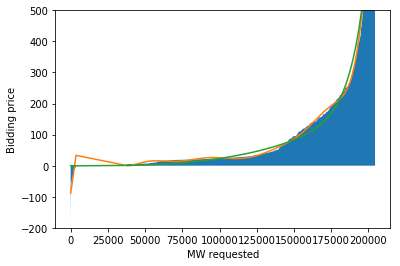

In [70]:
x = MeritOrderCurves[0,0][1]
y = MeritOrderCurves[0,0][0]
fig, ax = plt.subplots()
ax.stackplot(x,y)

poly = np.polyfit(x, y, 13)
poly2 = np.poly1d(poly)
ax.plot(x,poly2(x))

def func(x, a,b,d):
    #return a*np.exp(x/10000) + b*(x**3) + c*x +d * np.log(x) +e
    return a*np.exp(x/10000) + b*(x**3) +d * np.log(x)


popt, _ = curve_fit(func, x, y)
ax.plot(x, func(x, *popt))

ax.set_xlabel('MW requested')
ax.set_ylabel('Bidding price')
plt.ylim((-200,500))
#plt.savefig('MerritOrder1313.png',dpi=300)
plt.show()



In [ ]:
Create Random Merit

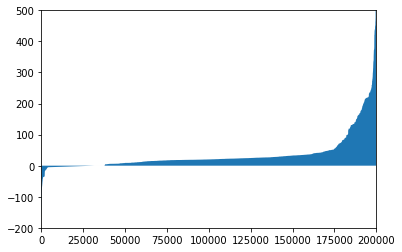

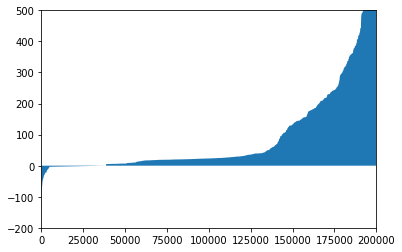

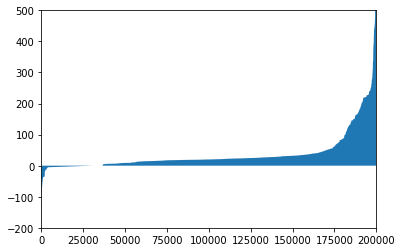

In [46]:
for i in range(3):
    num = np.random.randint(0,8000)
    x = MeritOrderCurves[num,0][1]
    y = MeritOrderCurves[num,0][0]
    fig, ax = plt.subplots()
    plt.ylim((-200,500))
    plt.xlim((0,200000))
    ax.stackplot(x,y)
    plt.show

<function matplotlib.pyplot.show(*args, **kw)>

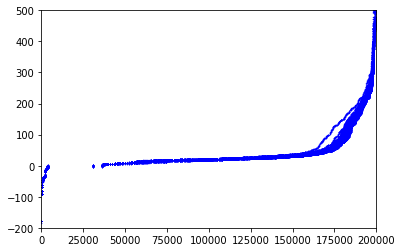

In [55]:
x = MeritOrderCurves[num,0][1]
fig, ax = plt.subplots()
plt.ylim((-200,500))
plt.xlim((0,200000))
for i in range(MeritOrderCurves.shape[0]):
    y = MeritOrderCurves[i,0][0]
    try:
        ax.scatter(x,y,c="Blue",s=.1)
    except:
        pass
plt.savefig('AllMeritOrders.png',dpi=600)
plt.show